<a href="https://colab.research.google.com/github/Harisuryatm/Computer-Vision/blob/master/Pneumonia_classification_using_Xray_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improvising Pneumonia Classifier:                                      

Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. 

 According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years old every year and is consistently estimated as the single leading cause of childhood mortality, killing more children than HIV/AIDS, malaria, and measles combined.                    

Thus , classifying pediatric chest X-rays to detect pneumonia and furthermore to distinguish viral and bacterial pneumonia to facilitate rapid referrals for children needing urgent intervention.Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.

### About the data:
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).           

Model is using grayscale images as for me it did not make too much sense to use X-Ray images as colorful images.


### Downloading dataset from kaggle:

In [1]:
# Uploading dataset from kaggle
from google.colab import files
files.upload()

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harisuriyatm","key":"5db0f57f932ff6e47050d5f02f6b38df"}'}

In [2]:
# downloading google api client
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# List available datasets.
!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imoore/60k-stack-overflow-questions-with-quality-rate               60k Stack Overflow Questions with Quality Rating     21MB  2020-09-08 09:26:05            418  
anikannal/solar-power-generation-data                               Solar Power Generation Data                           2MB  2020-08-18 15:52:03           2208  
ihelon/lego-minifigures-classification                              LEGO Minifigures Classification                      10MB  2020-09-06 16:42:41            453  
douglaskgaraujo/opportunity-insights-real-time-economic-tracker-us  Opportunity Insights real time Economic Tracker US   22MB  2020-09-07 18:23:07            186  
ruchi798/bookcro

In [3]:
# downloading from kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:30<00:00, 25.0MB/s]
100% 2.29G/2.29G [00:30<00:00, 80.7MB/s]


In [38]:
# unzip cat vs dog dataset files 
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Importing libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os,shutil
import cv2
import seaborn as sns

import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense,BatchNormalization , Flatten , MaxPool2D , Conv2D , Dropout , SeparableConv2D , LeakyReLU , Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau , EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix,accuracy_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Extracting the data:

In [4]:
# Image directory
input_path    = "/content/chest_xray/chest_xray/"
train_img_dir = "/content/chest_xray/chest_xray/train"
valid_img_dir = "/content/chest_xray/chest_xray/val"
test_img_dir  = "/content/chest_xray/chest_xray/test"

In [41]:
# moving some random images from training to validation
from shutil import move
from random import sample
def moveto_valid(train_path , valid_path,num_images):
  '''
  Moving images from train to validation
  Args : train_path  : train directory
         valid_path : validation directory
         num_images : number of images to move from train to validation directory
  '''
  for label in os.listdir(train_path):
    if not label.startswith('.'):
      random_files = sample(os.listdir(train_path + '/' + label),num_images)
      for filename in random_files:
        src_file = train_path + '/' + label + '/' + filename
        dest_folder = valid_path + '/' + label
        move(src_file,dest_folder)
             
      

In [5]:
# Moving from train to valid
moveto_valid(train_img_dir,valid_img_dir,91)

In [6]:
len(os.listdir(valid_img_dir + '/NORMAL'))

100

Set : train , Total number of NORMAL: 1250 , Total number of PNUEMONIA: 3784
Set : val , Total number of NORMAL: 99 , Total number of PNUEMONIA: 99
Set : test , Total number of NORMAL: 233 , Total number of PNUEMONIA: 389


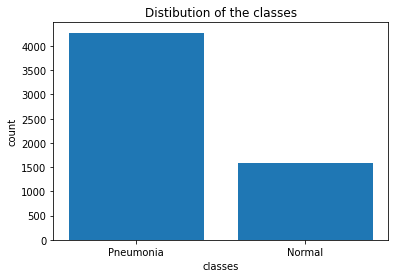

In [7]:
# Total no. of images in train , test and validation
num_normal = []
num_pnuemonia = []
for i , dir in enumerate(['train','val','test']):
  num_normal.append(len(os.listdir(input_path + '/' + dir + '/NORMAL')))
  num_pnuemonia.append(len(os.listdir(input_path + '/' + dir + '/PNEUMONIA')))
  print("Set : {} , Total number of NORMAL: {} , Total number of PNUEMONIA: {}".format(dir , num_normal[i]-1 , num_pnuemonia[i]-1))

distribution = [sum(num_pnuemonia),sum(num_normal)]

plt.bar(['Pneumonia','Normal'] , distribution)
plt.title('Distibution of the classes')
plt.xlabel('classes')
plt.ylabel('count')
plt.show()



The dataset that we have is imbalanced. This can be solved using Data Augmentation

In [8]:
# dimension of the image , epochs and batch size
img_width , img_height = 150 , 150
epochs = 15
batch_size = 32

(1317, 1857)


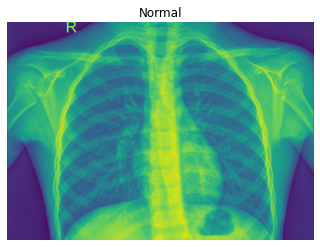

(762, 1106)


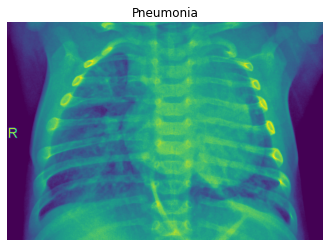

In [49]:
# Visualizing the images of both class
def plot(path,label):
  img = cv2.imread(path)
  img = cv2.cvtColor(img , cv2.COLOR_RGB2GRAY)
  print(img.shape)
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')
  plt.show()

plot('/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg','Normal')
plot('/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg','Pneumonia')

### Image Data Preprocessing:

In [9]:
# checking the channel first ot last to ensure it in input shape of each image in the network
if k.image_data_format() == 'channels_last':
  input_shape = (img_width,img_height,3)

else:

  input_shape = (3,img_width,img_height)  # 224,224,3

In [15]:
# image data generator for train,valid and test folders
# Data Augmentation
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        rescale = 1./255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    
# This is fed to the network in the specified batch sizes and image dimensions
train_gen = datagen.flow_from_directory(
    directory=train_img_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

valid_gen = datagen.flow_from_directory(
    directory=valid_img_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

Found 5034 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [12]:
# test data and their corresponding labels for prediction
def prepare_testdata(input_path,img_dims):
    '''
    Preparing the test data and their corresponding labels
    '''
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for im in (os.listdir(input_path + 'test' + cond)):
            img = cv2.imread(input_path+'test'+cond+im)
            #img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_dims, img_dims))
            #img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            #img = np.reshape(img, (img_dims,img_dims,1))
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return test_data , test_labels


In [13]:
test_data , test_labels = prepare_testdata(input_path,img_width)



In [35]:
# Image visualization
def plotImages(images_arr,labels,img_size): 
  # Image visualization
  
  fig, axes = plt.subplots(4,8, figsize=(20,20))
  axes = axes.flatten()
  for  idx , (img, ax) in enumerate(zip( images_arr, axes)):
    #im = img.reshape(img_size,img_size)
    if labels[idx] == 1:
      ax.set_title('Pneumonia')
    else:
      ax.set_title('Normal')
    ax.imshow(img.astype(np.uint8))
    ax.axis('off')
  plt.tight_layout()
  plt.show() 

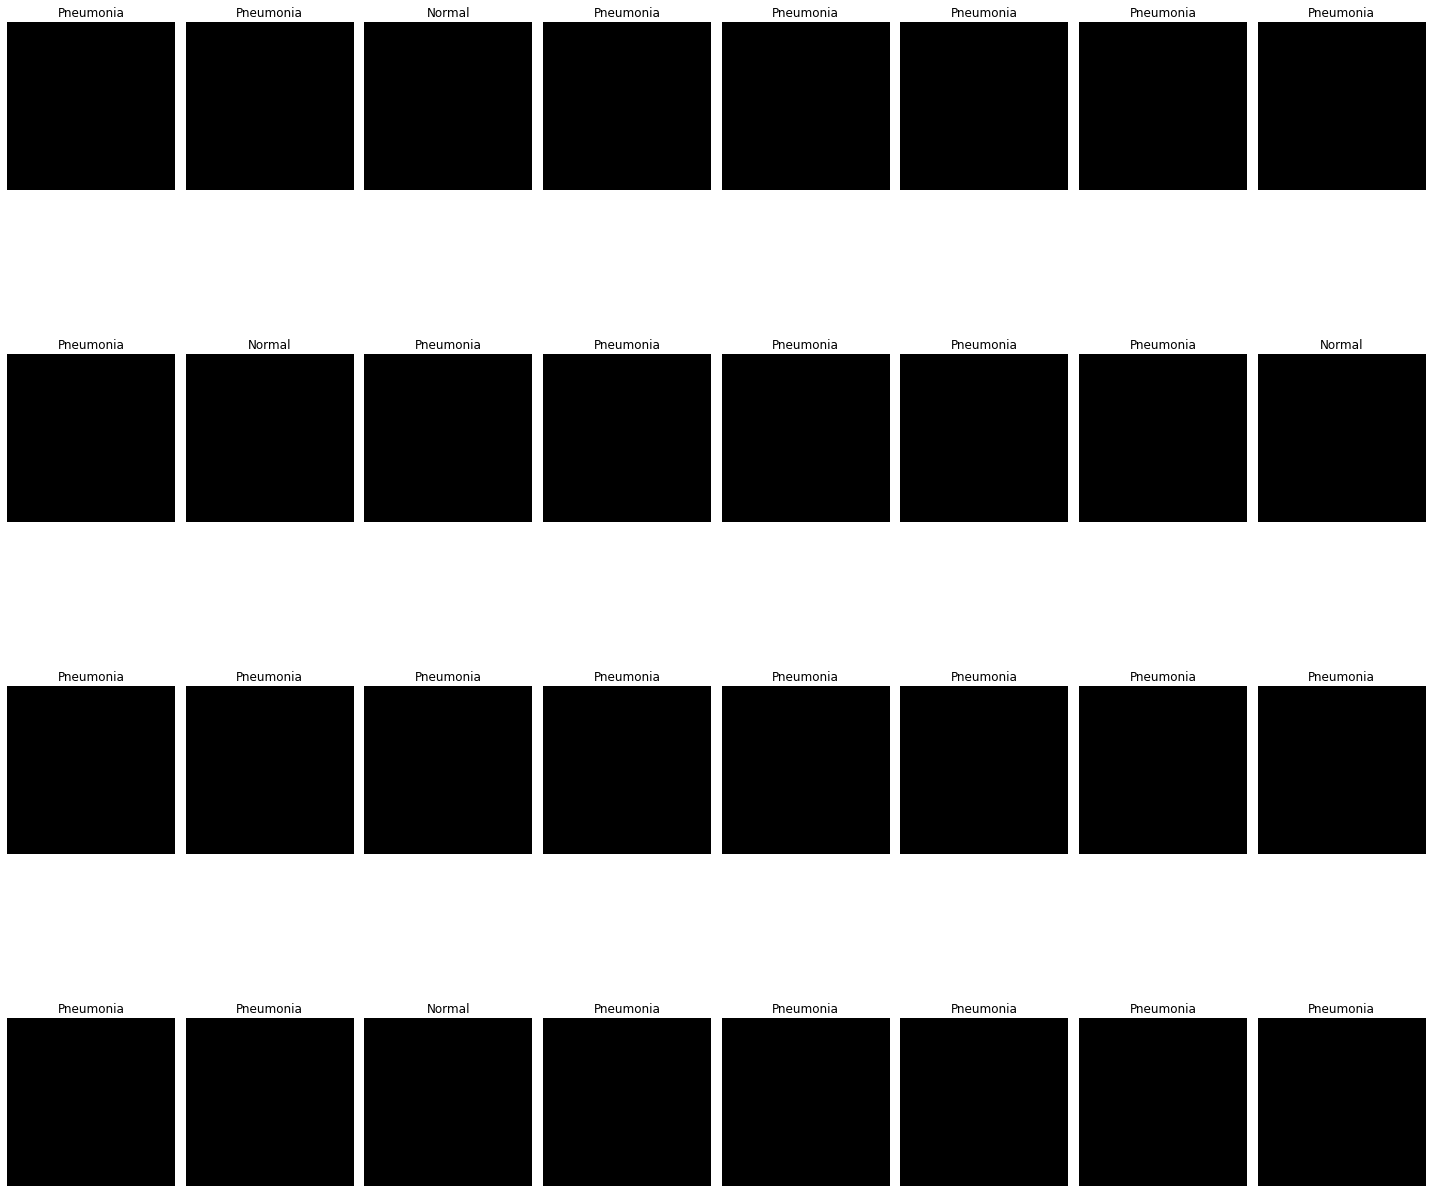

In [36]:
images,labels = next(train_gen)
plotImages(images,labels,150)
#print(labels)

### Building the network:

In [18]:
# Convolutiion neural network architecture
#model = Sequential()
#model.add(Conv2D(32 , (3,3) , activation= 'relu' ,padding= 'same', input_shape= input_shape))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Conv2D(32,(3,3),padding= 'same',activation='relu'))
#model.add(MaxPool2D(pool_size= (2,2)))
#model.add(Conv2D(64,(3,3),padding= 'same',activation= 'relu'))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(64 , activation= 'relu'))
#model.add(Dropout(0.5))
#model.add(Dense(1,activation= 'sigmoid'))

# Buidling much deeper model to increase the model's performance
model = Sequential()
                  # first conv layer
model.add(Conv2D(16,(3,3),activation= 'relu',padding= 'same',input_shape= input_shape))
model.add(Conv2D(16,(3,3),activation= 'relu',padding= 'same'))
model.add(MaxPool2D(pool_size= (2,2)))

# second conv layer
model.add(Conv2D(filters= 32,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(Conv2D(filters= 32,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2)))

# third conv layer
model.add(Conv2D(filters= 64,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(Conv2D(filters= 64,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2)))

# forth conv layer
model.add(Conv2D(filters= 128,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(Conv2D(filters= 128,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2)))
model.add(Dropout(0.2))

# fifth conv layer
model.add(Conv2D(filters= 256,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(Conv2D(filters= 256,kernel_size= (3,3),padding= 'same',activation= 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size= (2,2)))
model.add(Dropout(0.2))

# Fully conncected layers
model.add(Flatten())
model.add(Dense(512,activation= 'relu'))
model.add(Dropout(0.7))
model.add(Dense(128,activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation= 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1,activation= 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0

In [19]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [20]:
# prearing the model for training
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training the network with our dataset:

In [21]:
batch_size = 32 

history = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_gen.samples // batch_size, 
    epochs=epochs, 
    validation_data = valid_gen,
    validation_steps  = valid_gen.samples // batch_size,
    callbacks=[checkpoint, learning_rate_reduction]
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
157/157 [==============================] - 73s 465ms/step - loss: 0.7377 - accuracy: 0.7547 - val_loss: 5.9347 - val_accuracy: 0.5052
Epoch 2/20
157/157 [==============================] - 71s 455ms/step - loss: 0.3701 - accuracy: 0.8341 - val_loss: 21.9049 - val_accuracy: 0.4948
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8631
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
157/157 [==============================] - 71s 451ms/step - loss: 0.3193 - accuracy: 0.8631 - val_loss: 5.5272 - val_accuracy: 0.5052
Epoch 4/20
157/157 [==============================] - 70s 448ms/step - loss: 0.2415 - accuracy: 0.9080 - val_loss: 1.1992 - val_accuracy: 0.5990
Epoch 5/20
157/157 [==============================] - 70s 443ms/step - loss: 0.2174 - accuracy: 0.9204 - val_loss: 0.5085 - val_accuracy: 0.7135
Epoch 6/20
157/157 [=============

ValueError: ignored

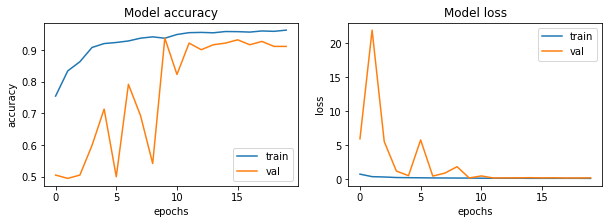

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:

model.save_weights('Chestxray_weights.h5')

In [24]:
preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((history.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[203  31]
 [ 25 365]]

TEST METRICS ----------------------
Accuracy: 91.02564102564102%
Precision: 92.17171717171718%
Recall: 93.58974358974359%
F1-score: 92.87531806615777

TRAIN METRIC ----------------------
Train acc: 96.28


## **Woowww!! Because of using Data Augmentation , Accuracy jumps from 62% to 87% to 88% , then atlast it crosses 91%.We increased 7% from before which is too great. Thats great initiative. F1-score gives model performance which is from 90% to 93%**

#### Accuracy and loss for previous model:

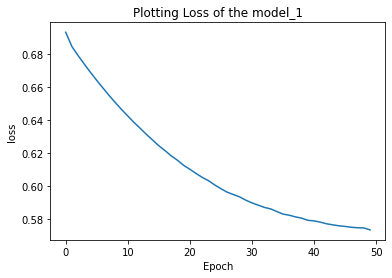

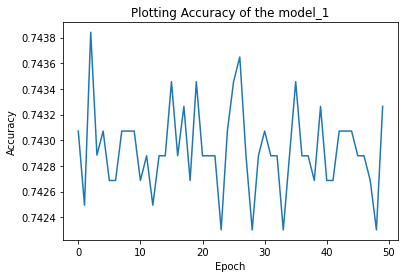

In [ ]:
plt.plot(list(range(50)),history.history['loss'])
plt.title('Plotting Loss of the model_1')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(list(range(50)),history.history['accuracy'])
plt.title('Plotting Accuracy of the model_1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()


Accuracy plots fluctuates alot.Final Loss and Accuracy of this model and its performance is not good.Again, training it with adding suitable Data Augmentation and additional network architecture gives us a good result.Thus we update the model using trial and error method.


In [ ]:
test_data.shape

(624, 150, 150, 1)